# <strong> 4a: Gesture Annotation Notebook

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [4]:
PARTICIPANT = 'TEST_VIDEO'
df = pd.read_csv(f'../Events/{PARTICIPANT}_events_found.csv')

In [5]:
def mark_peak_intervals(df):
    # Create a DataFrame to store peaks and min values
    peaks_df = pd.DataFrame(index=df.index)
    peaks_df['gesture_id'] = df['gesture_id']
    peaks_df['peaks'] = 0
    peaks_df['min'] = 0

    # Group by 'gesture_id' and find peaks for each gesture
    for gesture_id, group in df.groupby('gesture_id'):
        if group.shape[0] > 3:  # Need at least 3 points to define two peaks

            speeds = group['right_wrist_speed'].values
            peaks, _ = find_peaks(speeds, distance=1)
            # Sort peaks by prominence and take the two highest
            prominences = peak_prominences(speeds, peaks)[0]
            sorted_peaks = peaks[np.argsort(prominences)[-2:]]
            # Mark the intervals between the two highest peaks
            if sorted_peaks.size == 2:
                peaks_df.loc[group.index[min(sorted_peaks):max(sorted_peaks)+1], 'peaks'] = 1
                # Find the absolute smallest valley within the peak interval
                valley = np.argmin(speeds[min(sorted_peaks):max(sorted_peaks)+1]) + min(sorted_peaks)
                peaks_df.loc[group.index[valley], 'min'] = 1

    return peaks_df

def mark_crossings(df):
    # Add columns for crossing points
    df['right_wrist_delta_x_cross'] = 0
    df['right_wrist_delta_y_cross'] = 0

    # Group by 'gesture_id' and find crossings for each gesture
    for gesture_id, group in df.groupby('gesture_id'):
        if gesture_id != 'nan':  # Skip gesture_id = 0
            # Find where the right wrist delta x crosses 0
            delta_x = group['right_wrist_delta_x'].values
            cross_x = np.where(np.diff(np.sign(delta_x)))[0]
            df.loc[group.index[cross_x], 'right_wrist_delta_x_cross'] = 1

            # Find where the right wrist delta y crosses 0
            delta_y = group['right_wrist_delta_y'].values
            cross_y = np.where(np.diff(np.sign(delta_y)))[0]
            df.loc[group.index[cross_y], 'right_wrist_delta_y_cross'] = 1

    return df


# Apply the function to the df
peaks_data = mark_peak_intervals(df)
peaks_data.head()
# Align the peaks df with the original df
df['peaks'] = peaks_data['peaks']
df['min'] = peaks_data['min']


In [7]:
crossings_data = mark_crossings(df)

In [8]:
df.to_csv(f'../Gestures/{PARTICIPANT}_gestures_found.csv', index=False)

In [ ]:
# Filter the df to only include rows where 'min' and 'peaks' are equal to 1
min_df = df[df['min'] == 1]
peaks_df = df[df['peaks'] == 1]

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time_ms'], y=df['right_wrist_speed'], name='Speed'))
fig.add_trace(go.Scatter(x=peaks_df['time_ms'], y=peaks_df['right_wrist_speed'], name='Peaks', mode='markers'))
fig.add_trace(go.Scatter(x=min_df['time_ms'], y=min_df['right_wrist_speed'], name='Min', mode='markers'))
fig.update_layout(title='Speed with Peaks and Min Values',
                    # change size of the figure
                    width=1000,
                    height=800)
fig.show()

In [14]:
def plot_gesture(gesture_id):
    # Filter the data for the specific gesture_id
    gesture_data = df[df['gesture_id'] == gesture_id]
    peaks_gesture_data = peaks_df[peaks_df['gesture_id'] == gesture_id]
    min_gesture_data = min_df[min_df['gesture_id'] == gesture_id]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(data=gesture_data, x='time_ms', y='right_wrist_speed', label='Speed', ax=ax, color='black', linewidth=2)
    sns.scatterplot(data=peaks_gesture_data, x='time_ms', y='right_wrist_speed', label='Inter-Peak', color='grey', ax=ax, s=100)
    sns.scatterplot(data=min_gesture_data, x='time_ms', y='right_wrist_speed', label='Minimum', color='red', ax=ax, s=100)

    # Set the plot title and labels
    plt.title('Speed with Peaks and Min Values for Gesture {}'.format(gesture_id), fontsize=16)
    plt.xlabel('Time (ms)', fontsize=14)
    plt.ylabel('Right Wrist Speed', fontsize=14)

    # Set the limits of the x-axis and y-axis
    plt.xlim(gesture_data['time_ms'].min(), gesture_data['time_ms'].max())
    plt.ylim(gesture_data['right_wrist_speed'].min(), gesture_data['right_wrist_speed'].max())
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

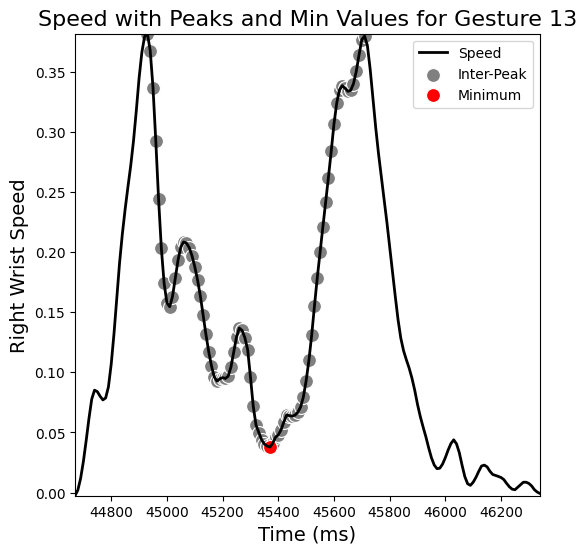

In [28]:
plot_gesture(13)